### NOTE
* shuffle() data before use. ATM commented out.

In [19]:
# Config parameters
dict_config_params = {}

# Data I/O
dict_config_params['data_dirs'] = []
dict_config_params['data_dirs'].append('../../data/simulator/track1-run1-pretty-centered/')
dict_config_params['data_dirs'].append('../../data/simulator/track2-run1-pretty-centered/')

dict_config_params['data_dirs'].append('../../data/simulator/track1-side-to-center/')
dict_config_params['data_dirs'].append('../../data/simulator/track2-side-to-center/')

dict_config_params['data_dirs'].append('../../data/simulator/track2-side-to-center-poles/')
# dict_config_params['data_dirs'].append('../../data/simulator/track2-side-to-center-poles-2/')
# dict_config_params['data_dirs'].append('../../data/simulator/track2-sharp-turns/')

dict_config_params['batch_size'] = 8  # 32

dict_config_params['angle_threshold'] = 0.05
dict_config_params['angle_correction'] = 0.2
dict_config_params['angle_noise'] = 0   # 0.15

# Data preprocessing
dict_config_params['convert_rbg2gray'] = False  # ATTN: img-preproc should be part of NN model!

# Data augmentation
dict_config_params['sample_drop_prob'] = 0.9
dict_config_params['mult_factor_samples_per_epoch'] = 1
dict_config_params['flip_images'] = True
if dict_config_params['flip_images']:
    dict_config_params['mult_factor_samples_per_epoch'] *= 2
    
dict_config_params['use_only_center_img'] = False
dict_config_params['use_one_of_three_imgs'] = False
if dict_config_params['use_only_center_img'] or dict_config_params['use_one_of_three_imgs']:
    dict_config_params['mult_factor_samples_per_epoch'] *= 1
else:
    dict_config_params['mult_factor_samples_per_epoch'] *= 3


# NN model params
dict_config_params['nn_conv_drop_prob'] = 0.25
dict_config_params['nn_dense_drop_prob'] = 0.25

# Debug
dict_config_params['dbg_data_generators'] = False

In [20]:
# Read data from the driving_log.csv file
import csv
import numpy as np

lines = []

for data_dir in dict_config_params['data_dirs']:
    
    with open(data_dir + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            
            steer_angle = float(line[3])
            drop_sample = False
            if abs(steer_angle) == 0.0: # dict_config_params['angle_threshold']
                sample_drop_prob = dict_config_params['sample_drop_prob']
                drop_sample = np.random.choice([True, False], p=[sample_drop_prob, 1-sample_drop_prob])

            if not drop_sample:
                line.append(data_dir)
                lines.append(line)
        
print("No. of lines read from CSV-file: {}".format(len(lines)))
#for line in lines:
#     print("line: {}".format(line))

No. of lines read from CSV-file: 1956


In [21]:
# Image preprocessing
def preprocess_image(image):
    if dict_config_params['convert_rbg2gray']:
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        return image

In [22]:
# Populate training data
# Do data augmentation by flipping images vertically
import cv2
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def get_data(batch_samples):
    images = []
    angles = []
    for batch_sample in batch_samples:
        path = batch_sample[-1] + 'IMG/'
        name_center = path + batch_sample[0].split('/')[-1]
        name_left = path + batch_sample[1].split('/')[-1]
        name_right = path + batch_sample[2].split('/')[-1]

        # Augmenting with vertically flipped image to balance the dataset skew towards leftward
        # steering angles. With the original training data, the car keeps going in anticlockwise
        # circles!               
        # print("name_center: {}".format(name_center))                
        angle_noise = dict_config_params['angle_noise']
        camera = np.random.choice(['center', 'left', 'right'])

        gate = True
        if dict_config_params['use_one_of_three_imgs']:
            gate = False
        
        steer_angle = float(batch_sample[3])
        if dict_config_params['use_only_center_img'] or (gate==True or camera=='center'):
            center_image = cv2.cvtColor(cv2.imread(name_center), cv2.COLOR_BGR2RGB)
            center_image = preprocess_image(center_image)
            flipped_image=center_image.copy()
            flipped_image=cv2.flip(center_image,1)
            images.extend((center_image, flipped_image))

            center_angle = steer_angle
            center_angle += np.random.normal(0, angle_noise)
            angles.extend((center_angle, -center_angle))

        if ~dict_config_params['use_only_center_img'] and (gate==True or camera == 'left'):
            left_image = cv2.cvtColor(cv2.imread(name_left), cv2.COLOR_BGR2RGB)
            left_image = preprocess_image(left_image)
            flipped_image=left_image.copy()
            flipped_image=cv2.flip(left_image,1)
            images.extend((left_image, flipped_image))

            left_angle = steer_angle + dict_config_params['angle_correction']
            left_angle += np.random.normal(0, angle_noise)
            angles.extend((left_angle, -left_angle))

        if ~dict_config_params['use_only_center_img'] and (gate==True or camera == 'right'):
            right_image = cv2.cvtColor(cv2.imread(name_right), cv2.COLOR_BGR2RGB)
            right_image = preprocess_image(right_image)
            flipped_image=right_image.copy()
            flipped_image=cv2.flip(right_image,1)
            images.extend((right_image, flipped_image))

            right_angle = steer_angle - dict_config_params['angle_correction']
            right_angle += np.random.normal(0, angle_noise)
            angles.extend((right_angle, -right_angle))                                   

            
    if dict_config_params['convert_rbg2gray']:
        X = np.expand_dims(np.array([img for img in images]), 4)
    else:
        X = np.array(images)
        
    y = np.array(angles)
    return X, y

def generator(samples, batch_size=32):
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates        
        # shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            X, y = get_data(batch_samples)                        
            yield shuffle(X, y)    
            
# Generator functions
train_samples, validation_samples = train_test_split(shuffle(lines), test_size=0.2)
print("num_train_samples = {}".format(len(train_samples)))
print("num_validation_samples = {}".format(len(validation_samples)))
print()

train_generator = generator(train_samples, batch_size=dict_config_params['batch_size'])
validation_generator = generator(validation_samples, batch_size=dict_config_params['batch_size'])

# Generators debugging
if True: #dict_config_params['dbg_data_generators']:
    X_debug_gen, y_debug_gen =next(train_generator)
    print("generator image shape = {}".format(X_debug_gen[0].shape))
    print()
    print("X_debug_gen shape = {}".format(X_debug_gen.shape))
    print("y_debug_gen shape = {}".format(y_debug_gen.shape))
    print()

num_train_samples = 1564
num_validation_samples = 392

generator image shape = (160, 320, 3)

X_debug_gen shape = (48, 160, 320, 3)
y_debug_gen shape = (48,)



Go to <a href=#bookmark>my bookmark</a>

length of data = 9384
no. of bins = 46



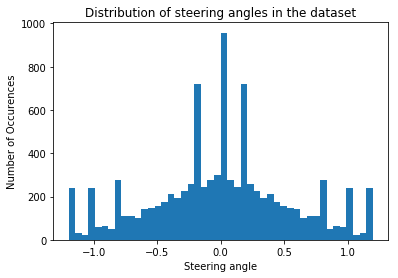

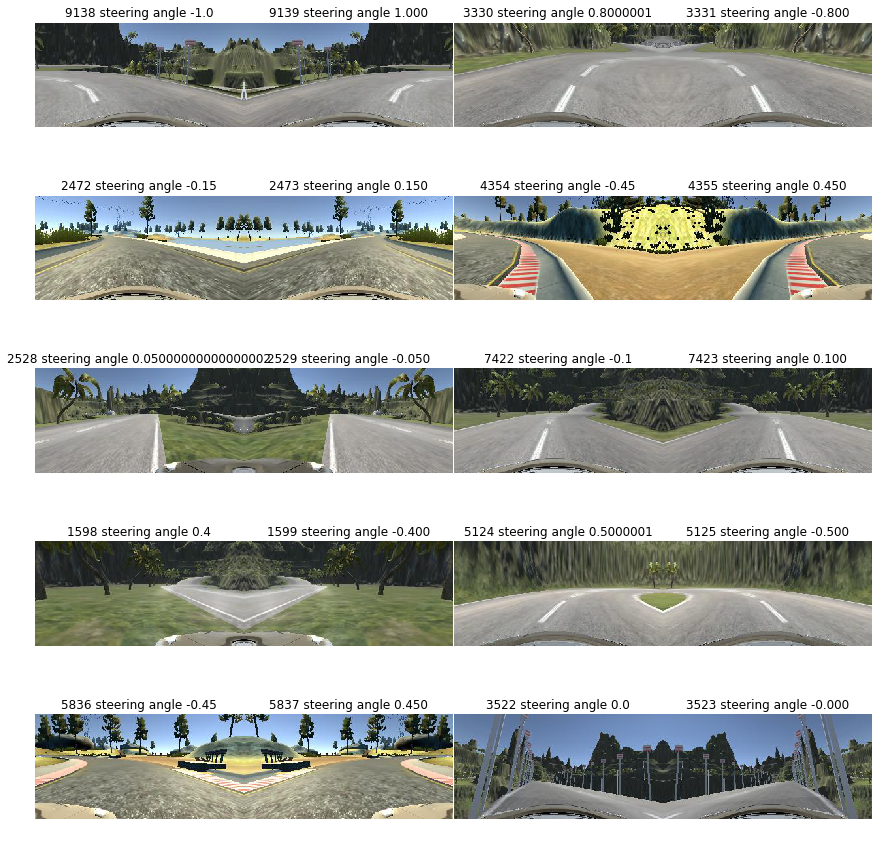

In [23]:
### Data exploration visualization code
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Visualizations will be shown in the notebook.
get_ipython().run_line_magic('matplotlib', 'inline')


def visualize_images(X, y, num_random_imgs=10, color_map=None):
    random.seed(2342)
    
    fig, axs = plt.subplots(int(num_random_imgs/4), 4, figsize=(15, 15))
    fig.subplots_adjust(hspace = .4, wspace=.003)
    axs = axs.ravel()
    for i in range(0, num_random_imgs, 2):
        index = random.randint(0, len(X)) - 1
        if index%2!=0:
            index+=1 # We want an even index
        
        if color_map=='gray':
            image = X[index].squeeze()
            image_flipped = X[index+1].squeeze()
        else:
            image = X[index]
            image_flipped = X[index+1]
            #print("image shape = {}".format(image_flipped.shape))
                
        axs[i].axis('off')
        axs[i].imshow(image, color_map)
        axs[i].set_title("{} steering angle {}".format(index, y[index]))
        
        axs[i+1].axis('off')
        axs[i+1].imshow(image_flipped, color_map)
        axs[i+1].set_title("{0} steering angle {1:.3f}".format(index+1, y[index+1]))

def plot_histogram(data):    
    len_data = len(data)
    print("length of data = {}".format(len_data))
    num_bins=int(2*len_data/400)
    print("no. of bins = {}".format(num_bins))
    print()
    
    plt.hist(data, bins=num_bins)
    # plt.xlim(xmax=n_classes-1)
    plt.ylabel('Number of Occurences')
    plt.xlabel('Steering angle')
    plt.title('Distribution of steering angles in the dataset')
        
if True: #dict_config_params['dbg_data_generators']:        
    X_plot, y_plot = get_data(train_samples)
    #print("y_plot = {}".format(y_plot))
    plot_histogram(y_plot)
    
    color_map = None
    if dict_config_params['convert_rbg2gray']:
        color_map = 'gray'
    visualize_images(X_plot, y_plot, num_random_imgs=20, color_map=color_map)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_4 (Cropping2D)        (None, 80, 320, 3)    0           cropping2d_input_4[0][0]         
____________________________________________________________________________________________________
lambda_4 (Lambda)                (None, 80, 320, 3)    0           cropping2d_4[0][0]               
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 38, 158, 24)   1824        lambda_4[0][0]                   
____________________________________________________________________________________________________
activation_25 (Activation)       (None, 38, 158, 24)   0           convolution2d_16[0][0]           
___________________________________________________________________________________________

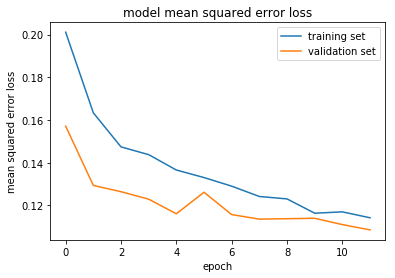

In [24]:
from model import configure_tensorflow_session, get_model_single_layer, \
                  get_model_single_layer_cropped, get_model_lenet, \
                  get_model_nvidia_arch

configure_tensorflow_session()

# model = get_model_single_layer()
# model = get_model_single_layer_cropped()
# model = get_model_lenet()
model = get_model_nvidia_arch(dict_config_params)

model.summary()

model.compile(loss='mse', optimizer='adam')

# X_train, y_train = shuffle(np.array(images), np.array(measurements)) 
# history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle='True', nb_epoch=12)

print("no. of train_samples = {}".format(len(train_samples)))
print("no. of validation_samples = {}".format(len(validation_samples)))
print()

mult_factor = dict_config_params['mult_factor_samples_per_epoch']
print("mult_factor = {}".format(mult_factor))
print()
history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch= mult_factor*len(train_samples), 
                                     validation_data=validation_generator, 
                                     nb_val_samples=mult_factor*len(validation_samples), 
                                     nb_epoch=12)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')